<a href="https://colab.research.google.com/github/hwon-n/section6_project1/blob/main/CP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install eli5

     |████████████████████████████████| 106 kB 13.8 MB/s 


In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 13.9 MB/s 


In [ ]:
!pip install yellowbrick

     |████████████████████████████████| 274 kB 12.9 MB/s 


In [ ]:
!pip install -U yellowbrick

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 350 kB/s 


In [ ]:
# !pip install -U pandas-profiling

In [147]:
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [148]:
# 데이터 불러오기

train = pd.read_csv('/content/drive/MyDrive/Training Data.csv')

train.rename(columns = {'Married/Single': 'Married_Or_Single'}, inplace = True)

target = 'Risk_Flag'
train, test = train_test_split(train, train_size = 0.8, random_state = 42, stratify = train[target])
train, val = train_test_split(train, train_size = 0.8, random_state = 42, stratify = train[target])

train.shape, val.shape, test.shape

((161280, 13), (40320, 13), (50400, 13))

## 데이터 확인


In [ ]:
# train.profile_report()

In [ ]:
train.head().T

,81706,71073,101509,122745,45546
Id,81707,71074,101510,122746,45547
Income,6239581,9339198,12608,5453088,4859415
Age,38,67,64,34,23
Experience,8,14,19,20,13
Married_Or_Single,single,married,single,single,single
House_Ownership,rented,rented,norent_noown,norent_noown,rented
Car_Ownership,yes,yes,no,yes,no
Profession,Air_traffic_controller,Hotel_Manager,Physician,Firefighter,Geologist
CITY,Thane,Guntakal,Dehradun,Chennai,Bhilwara
STATE,Maharashtra,Andhra_Pradesh,Uttarakhand,Tamil_Nadu,Rajasthan


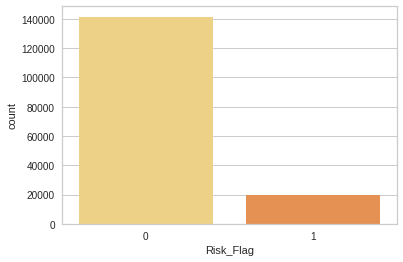

In [149]:
%matplotlib inline

target_colors = ['#fed976', '#fd8d3c']

ax = sns.set_palette('muted')
ax = sns.countplot(data = train, x = target, palette = target_colors)

plt.show()

# 0 -> 1로 바꿔주기
# 0: 대출 가능, 1: 대출 불가능 

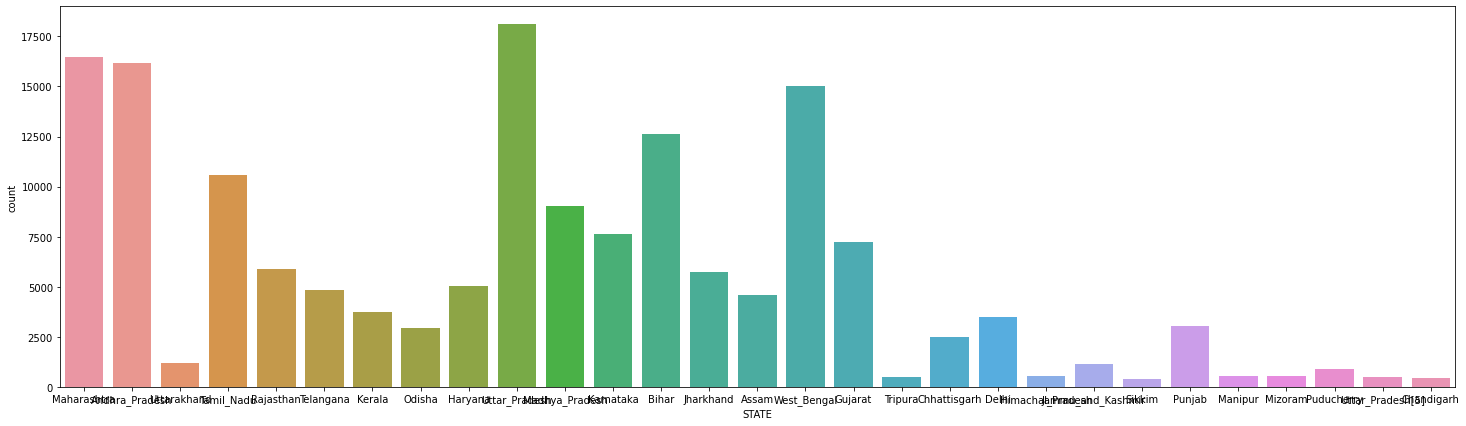

In [ ]:
# STATE 탐색

plt.figure(figsize=(25,7))
ax = sns.countplot(data = train, x = 'STATE')
plt.show()

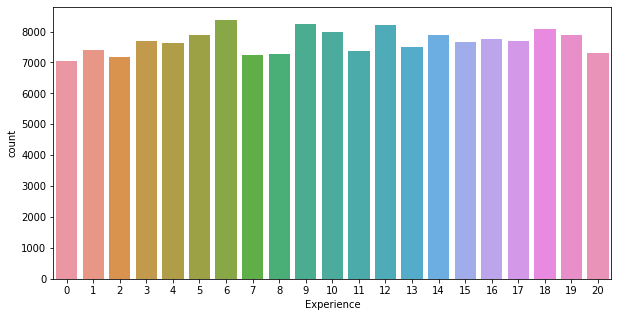

In [ ]:
# Experience 탐색

plt.figure(figsize=(10,5))
ax = sns.countplot(data = train, x = 'Experience')
plt.show()

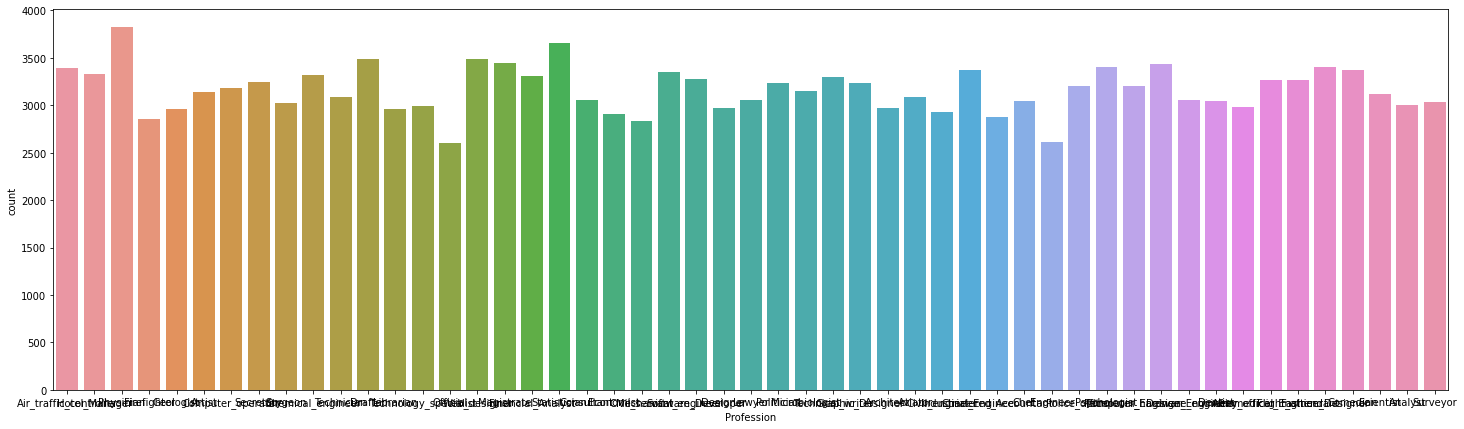

In [ ]:
# Profession 탐색

plt.figure(figsize=(25, 7))
ax = sns.countplot(data = train, x = 'Profession')
plt.show()

In [ ]:
len(train.Profession.unique())

51

In [ ]:
len(train.STATE.unique())

29

In [ ]:
len(train.CITY.value_counts())

317

In [ ]:
house = train.House_Ownership.value_counts()
car = train.Car_Ownership.value_counts()
marr_sin = train.Married_Or_Single.value_counts()

# 색상 지정
pink = ['#F198AF', '#9F81CD', '#EF6D6D']
green = ['#65C18C', '#C1F4C5']
yellow = ['#FFCC00', '#FFEE00', '#FFFF66', '#FFF18D']

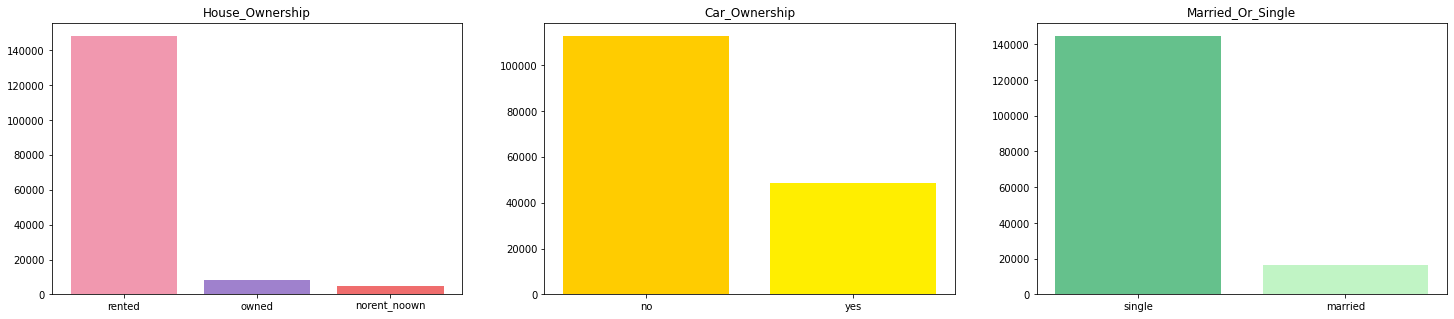

In [ ]:
plt.figure(figsize = (25, 5))
plt.subplot(1, 3, 1)
plt.bar(house.index, house.values, color = pink)
plt.title('House_Ownership')

plt.subplot(1, 3, 2)
plt.bar(car.index, car.values, color = yellow)
plt.title('Car_Ownership')

plt.subplot(1, 3, 3)
plt.bar(marr_sin.index, marr_sin.values, color = green)
plt.title('Married_Or_Single')

plt.show();

## 데이터 전처리

In [ ]:
# 지역 분류
north_state = ['West_Bengal', 'Bihar', 'Assam', 'Uttarakhand', 'Uttar_Paradesh', 'Uttar_Pradesh[5]',
               'Jammu_and_Kashmir', 'Rajasthan', 'Gujarat', 'Punjab', 'Manipur', 
                'Haryana', 'Sikkim', 'Mizoram', 'Madhya_Pradesh', 'Tripura',
               'Jharkhand', 'Chandigarh', 'Himachal_Pradesh']
south_state = ['Karnataka', 'Tamil_Nadu', 'Kerala', 'Andhra_Pradesh', 'Telangana', 
               'Maharashtra', 'Chhattisgarh', 'Odisha', 'Puducherry']

In [ ]:
# 직업 분류
natural_sciences = ['Mechanical_engineer', 'Psychologist', 'Scientist', 'Dentist', 'Chemical_engineer',
                    'Engineer', 'Petroleum_Engineer', 'Drafter', 'Microbiologist', 'Biomedical_Engineer',
                    'Aviator', 'Technician', 'Surgeon', 'Architect', 'Software_Developer', 
                    'Industrial_Engineer', 'Web_designer', 'Physician', 'Air_traffic_controller',
                    'Computer_operator', 'Civil_engineer', 'Geologist', 'Computer_hardware_engineer',
                    'Technology_specialist']
liberal_arts = ['Economist', 'Financial_Analyst', 'Magistrate', 'Official', 'Chef', 'Surveyor',
                'Analyst', 'Artist', 'Politician', 'Lawyer', 'Secretary', 'Designer', 'Comedian',
                'Statistician', 'Police_officer', 'Technical_writer', 'Chartered_Accountant',
                'Fashion_Designer', 'Graphic_Designer', 'Consultant', 'Firefighter', 'Flight_attendant',
                'Design_Engineer', 'Army_officer', 'Civil_servant', 'Hotel_Manager', 'Librarian']

len(natural_sciences), len(liberal_arts)

(24, 27)

In [ ]:
not_own = ['rented', 'norent_noown']

In [ ]:
def age(age):
  if age > 60:
    return 'over 60s'
  elif age >= 40:
    return '4-50s'
  elif age >= 30:
    return '30s'
  else:
    return 'under 30s'

def region(state):
  if state in north_state:
    return 'North Area'
  elif state in south_state:
    return 'South Area'
  elif state == 'Delhi':
    return 'Capital'

def exp(exp):
  if exp <= 2:
    return 'Entry'
  elif exp <= 5:
    return 'Intermediate'
  elif exp <= 10:
    return 'Mid'
  else:
    return 'Senior'


def job_year(year):
  if year < 5:
    return 1
  elif year <= 10:
    return 2
  else:
    return 3

def house(h):
  if h in not_own:
    return 'not owned'
  else:
    return h

def prof(prof):
  if prof in natural_sciences:
    return 'Natural Sciences'
  elif prof in liberal_arts:
    return 'Liberal Arts'
  else:
    return 'No Info'

In [ ]:
def feature(df):
  cols = ['Id', 'CITY']

  df.drop(columns = cols, inplace = True)
  df.reset_index(drop = True, inplace = True)

  if 'Risk_Flag' in df.columns:
    df.Risk_Flag = df.Risk_Flag.apply(lambda x: 1 if x == 0 else 0)

  df.Age = df.Age.apply(age)
  df.CURRENT_JOB_YRS = df.CURRENT_JOB_YRS.apply(job_year)
  df.STATE = df.STATE.apply(region)
  df.Experience = df.Experience.apply(exp)
  df.House_Ownership = df.House_Ownership.apply(house)
  df.Profession = df.Profession.apply(prof)

  return df

In [ ]:
train = feature(train)
val = feature(val)
test = feature(test)

In [ ]:
train.head().T

,0,1,2,3,4
Income,Mid,High,Low,Mid,Mid
Age,30s,over 60s,over 60s,30s,under 30s
Experience,Mid,Senior,Senior,Senior,Senior
Married_Or_Single,single,married,single,single,single
House_Ownership,not owned,not owned,not owned,not owned,not owned
Car_Ownership,yes,yes,no,yes,no
Profession,Natural Sciences,Liberal Arts,Natural Sciences,Liberal Arts,Natural Sciences
STATE,South Area,South Area,North Area,South Area,North Area
CURRENT_JOB_YRS,2,3,2,2,2
CURRENT_HOUSE_YRS,13,14,11,10,13


#### 데이터 전처리 결과 확인

In [ ]:
prof = train.Profession.value_counts()
age = train.Age.value_counts()
exp = train.Experience.value_counts()
houseP = train.House_Ownership.value_counts()
region = train.STATE.value_counts()
job_yrs = train.CURRENT_JOB_YRS.value_counts()

In [ ]:
color1 = ['#9ba9ff', '#afb1ff', '#cebeff', '#eccaff']
color2 = ['#71a5de', '#abc4ff', '#c1d3fe', '#d7e3fc']
color3 = ['#a5eeaa', '#c4f39d', '#e3f790', '#f3f98a']

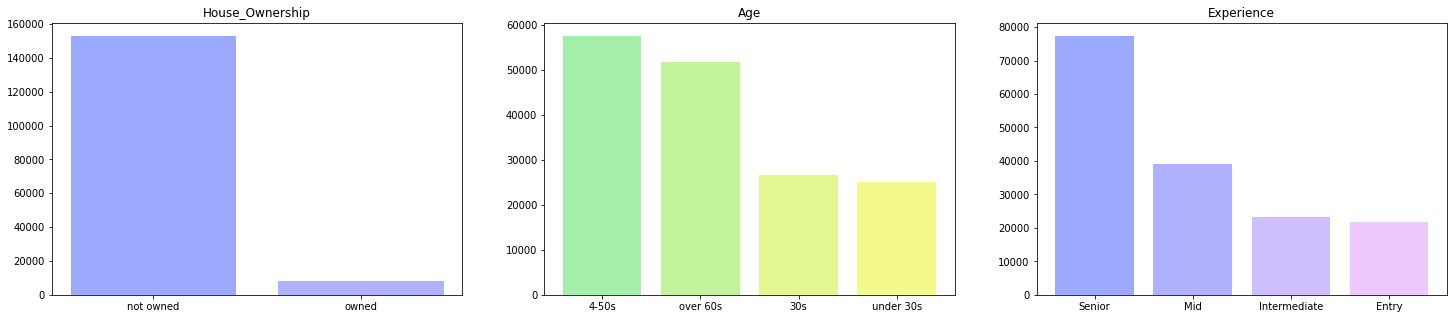

In [ ]:
plt.figure(figsize = (25, 5))

plt.subplot(1, 3, 1)
plt.bar(houseP.index, houseP.values, color = color1)
plt.title('House_Ownership')

plt.subplot(1, 3, 2)
plt.bar(age.index, age.values, color = color3)
plt.title('Age')

plt.subplot(1, 3, 3)
plt.bar(exp.index, exp.values, color = color1)
plt.title('Experience')


plt.show()


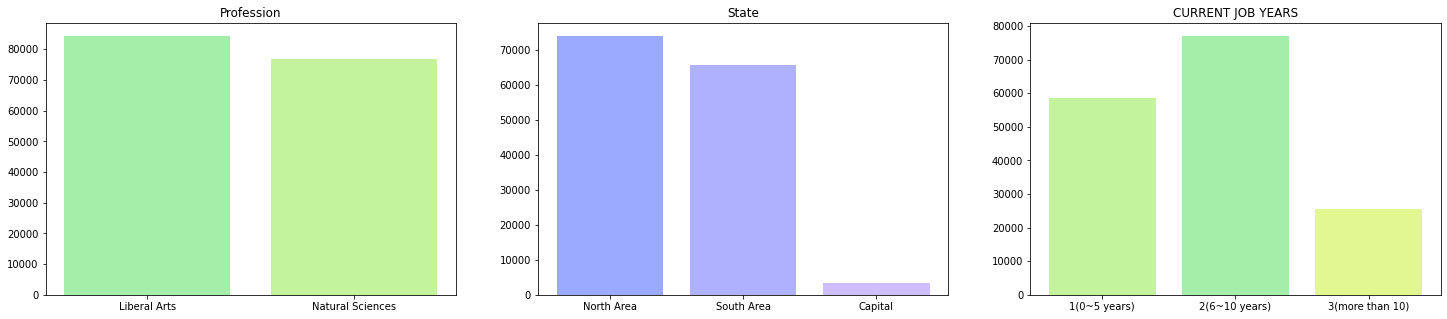

In [ ]:
plt.figure(figsize = (25, 5))

plt.subplot(1, 3, 1)
plt.bar(prof.index, prof.values, color = color3)
plt.title('Profession')

plt.subplot(1, 3, 2)
plt.bar(region.index, region.values, color = color1)
plt.title('State')

plt.subplot(1, 3, 3)
plt.bar(job_yrs.index, job_yrs.values, color = color3)
plt.xticks([1, 2, 3], ['1(0~5 years)', '2(6~10 years)', '3(more than 10)'])
plt.title('CURRENT JOB YEARS')

plt.show()

In [ ]:
train.Risk_Flag.value_counts()

1    141442
0     19838
Name: Risk_Flag, dtype: int64

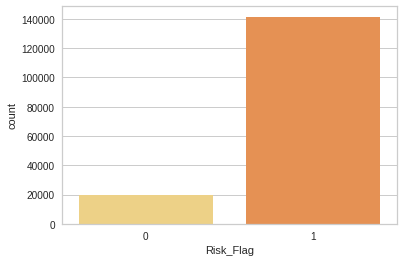

In [ ]:
%matplotlib inline

ax = sns.set_palette('muted')
ax = sns.countplot(data = train, x = target, palette = target_colors)

plt.show()

## 모델 비교
(HIstGradientBoostingClassifier vs LightGBM vs XGBClassifier vs ExtraTreesClassifier)


In [ ]:
X_train = train.drop(columns = target)
y_train = train[target]

X_val = val.drop(columns = target)
y_val = val[target]

X_test = test.drop(columns = target)
y_test = test[target]

In [ ]:
ord_list = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'House_Ownership', 'Car_Ownership']
ord_mapping = [
           {'col': 'Age', 'mapping': {'under 30s': 1, '30s': 2, '4-50s': 3, 'over 60': 4, 'NaN': 0}},
           {'col': 'Experience', 'mapping': {'Entry': 1, 'Intermediate': 2, 'Mid': 3, 'Senior': 4, 'NaN': 0}},
           {'col': 'CURRENT_JOB_YRS', 'mapping': {3: 3, 2: 2, 1: 1, 'NaN': 0}},
           {'col': 'House_Ownership', 'mapping': {'owned': 2, 'not owned': 1, 'NaN': 0}},
           {'col': 'Car_Ownership', 'mapping': {'yes': 2, 'no': 1, 'NaN': 0}}
]

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder, CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
# HistGradientBoostingClassifier

hist_pipe = make_pipeline(
    OrdinalEncoder(cols = ord_list, mapping = ord_mapping),
    TargetEncoder(),
    SimpleImputer(),
    StandardScaler(),
    HistGradientBoostingClassifier(
        max_iter = 200,
        learning_rate = 0.3,
        random_state = 42
    )
)
hist_pipe.fit(X_train, y_train)
y_pred = hist_pipe.predict(X_val)
f1 = f1_score(y_val, y_pred)


print(f'Validation Score: {hist_pipe.score(X_val, y_val):.4f}')
print(f'f1 Score: {f1:.4f}')
print(f'ROC Score: {roc_auc_score(y_val, y_pred):.4f}')
print(classification_report(y_val, y_pred))

Validation Score: 0.8856
f1 Score: 0.9378
ROC Score: 0.5877
              precision    recall  f1-score   support

           0       0.61      0.19      0.29      4959
           1       0.90      0.98      0.94     35361

    accuracy                           0.89     40320
   macro avg       0.75      0.59      0.62     40320
weighted avg       0.86      0.89      0.86     40320



In [ ]:
# LightGBM


light_pipe = make_pipeline(
    OrdinalEncoder(cols = ord_list, mapping = ord_mapping),
    TargetEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LGBMClassifier(
        boosting = 'rf',
        bagging_fraction = 0.2,
        bagging_freq = 1,
        random_state = 42
    )
)
light_pipe.fit(X_train, y_train)
y_pred = light_pipe.predict(X_val)
f1 = f1_score(y_val, y_pred)

print(f'Validation Score: {light_pipe.score(X_val, y_val):.4f}')
print(f'f1 Score: {f1:.4f}')
print(f'ROC Score: {roc_auc_score(y_val, y_pred):.4f}')
print(classification_report(y_val, y_pred))

Validation Score: 0.8774
f1 Score: 0.9346
ROC Score: 0.5023
              precision    recall  f1-score   support

           0       0.73      0.00      0.01      4959
           1       0.88      1.00      0.93     35361

    accuracy                           0.88     40320
   macro avg       0.80      0.50      0.47     40320
weighted avg       0.86      0.88      0.82     40320



In [ ]:
# XGBClassifier


xgb_pipe = make_pipeline(
    OrdinalEncoder(cols = ord_list, mapping = ord_mapping),
    TargetEncoder(),
    SimpleImputer(),
    StandardScaler(),
    XGBClassifier(
        max_depth = 6,
        reg_alpha = 0.9,
        reg_lambda = 0.2,
        random_state = 42
    )
)
xgb_pipe.fit(X_train, y_train)
y_pred = xgb_pipe.predict(X_val)
f1 = f1_score(y_val, y_pred)

print(f'Validation Score: {xgb_pipe.score(X_val, y_val):.4f}')
print(f'f1 Score: {f1:.4f}')
print(f'ROC Score: {roc_auc_score(y_val, y_pred):.4f}')
print(classification_report(y_val, y_pred))

Validation Score: 0.8779
f1 Score: 0.9349
ROC Score: 0.5061
              precision    recall  f1-score   support

           0       0.70      0.01      0.03      4959
           1       0.88      1.00      0.93     35361

    accuracy                           0.88     40320
   macro avg       0.79      0.51      0.48     40320
weighted avg       0.86      0.88      0.82     40320



In [ ]:
# ExtraTreesClassifier

extra_pipe = make_pipeline(
    OrdinalEncoder(cols = ord_list, mapping = ord_mapping),
    TargetEncoder(),
    SimpleImputer(),
    StandardScaler(),
    ExtraTreesClassifier(
        min_samples_split = 3,
        random_state = 42
    )
)
extra_pipe.fit(X_train, y_train)
y_pred =extra_pipe.predict(X_val)
f1 = f1_score(y_val, y_pred)

print(f'Validation Score: {extra_pipe.score(X_val, y_val):.4f}')
print(f'f1 Score: {f1:.4f}')
print(f'ROC Score: {roc_auc_score(y_val, y_pred):.4f}')
print(classification_report(y_val, y_pred))

Validation Score: 0.8896
f1 Score: 0.9368
ROC Score: 0.7567
              precision    recall  f1-score   support

           0       0.55      0.58      0.56      4959
           1       0.94      0.93      0.94     35361

    accuracy                           0.89     40320
   macro avg       0.74      0.76      0.75     40320
weighted avg       0.89      0.89      0.89     40320



## 하이퍼파라미터 튜닝

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
extra_pipe = make_pipeline(
    OrdinalEncoder(cols = ord_list, mapping = ord_mapping),
    TargetEncoder(),
    SimpleImputer(),
    StandardScaler(),
    ExtraTreesClassifier(
        random_state = 42
    )
)

In [ ]:
for i in list(range(2, 11)):
  scores = cross_val_score(extra_pipe, X_train, y_train, cv = i, scoring = 'f1')
  print('k = ', i)
  print('f1 score: ', scores)
  print(f'f1 score mean: {scores.mean():,.8f}\n')

k =  2
f1 score:  [0.93666068 0.93715841]
f1 score mean: 0.93690954

k =  3
f1 score:  [0.93572076 0.9359249  0.93719044]
f1 score mean: 0.93627870

k =  4
f1 score:  [0.93538121 0.93581792 0.93759941 0.93741644]
f1 score mean: 0.93655374

k =  5
f1 score:  [0.93585509 0.93471868 0.93554289 0.9369626  0.93735424]
f1 score mean: 0.93608670

k =  6
f1 score:  [0.93656645 0.93532253 0.93482023 0.93663337 0.93688304 0.93720861]
f1 score mean: 0.93623904

k =  7
f1 score:  [0.93720959 0.93496664 0.93506882 0.93571961 0.93672713 0.93746108
 0.9364727 ]
f1 score mean: 0.93623222

k =  8
f1 score:  [0.93705379 0.93479991 0.93545535 0.93447342 0.93597094 0.93785053
 0.93830254 0.93517092]
f1 score mean: 0.93613467

k =  9
f1 score:  [0.93748402 0.93503503 0.935731   0.93423455 0.93587367 0.93701141
 0.9367194  0.9369965  0.93573331]
f1 score mean: 0.93609099

k =  10
f1 score:  [0.93666833 0.93611741 0.93473774 0.93529747 0.93514533 0.93680666
 0.93676915 0.93564957 0.93781165 0.93534821]
f1 sc

In [ ]:
# dists = {
#     'extratreesclassifier__n_estimators': [100, 250, 400],
#     'extratreesclassifier__max_depth': [12, 8, 4, None],
#     'extratreesclassifier__min_samples_split': [2, 4, 8, 12],
#     'extratreesclassifier__min_samples_leaf': [1, 3, 5, 8],
#     'extratreesclassifier__max_features': [1, 4, 7, 10]
# }

# clf = GridSearchCV(
#     extra_pipe,
#     dists,
#     cv = 2,
#     n_jobs = -1
# )

# clf.fit(X_train, y_train)

# print('best_hyperparameter: ', clf.best_params_)
# print('best_f1_score: ', clf.best_score_)

In [ ]:
final_pipe = Pipeline([
  (
      'preprocessing', make_pipeline(
          OrdinalEncoder(cols = ord_list, mapping = ord_mapping),
          TargetEncoder(),
          SimpleImputer(),
          StandardScaler()
      )
  ),
  (
       'tree', ExtraTreesClassifier(
           n_estimators = 250,
           class_weight = 'balanced',
           max_features = 'sqrt',
           min_samples_split = 8,
           random_state = 42)
   )
])

final_pipe.fit(X_train, y_train)
y_pred =final_pipe.predict(X_val)
y_test_pred = final_pipe.predict(X_test)
f1 = f1_score(y_val, y_pred)

print('Accuracy: ', accuracy_score(y_val, y_pred))
print('Validation Score: ',final_pipe.score(X_val, y_val))
print('f1 Score: ', f1)
print('ROC Score: ', roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

print('\n\n-----------------------------\n\n')

print('Test Score: ', final_pipe.score(X_test, y_test))
print('f1 Score: ', f1_score(y_test, y_test_pred))
print('ROC Score: ', roc_auc_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Accuracy:  0.8749007936507937
Validation Score:  0.8749007936507937
f1 Score:  0.9252785020146954
ROC Score:  0.849533340611133
              precision    recall  f1-score   support

           0       0.49      0.82      0.62      4959
           1       0.97      0.88      0.93     35361

    accuracy                           0.87     40320
   macro avg       0.73      0.85      0.77     40320
weighted avg       0.91      0.87      0.89     40320



-----------------------------


Test Score:  0.8746031746031746
f1 Score:  0.9250652122361869
ROC Score:  0.8502165343691526
              precision    recall  f1-score   support

           0       0.49      0.82      0.62      6199
           1       0.97      0.88      0.93     44201

    accuracy                           0.87     50400
   macro avg       0.73      0.85      0.77     50400
weighted avg       0.91      0.87      0.89     50400



## 결과 시각화

In [ ]:
from sklearn.metrics import roc_curve
from yellowbrick.classifier import ROCAUC, ClassificationReport, ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.style import set_palette

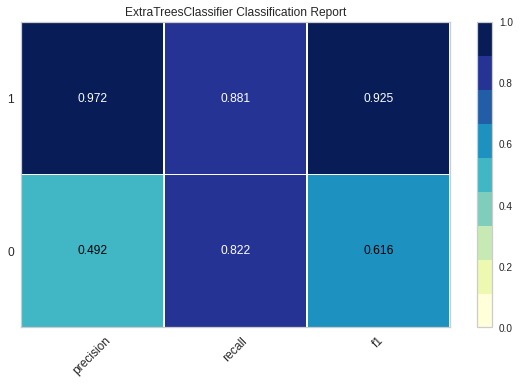

In [ ]:
report = ClassificationReport(final_pipe, classes = [0, 1], cmap = 'YlGnBu')
report.fit(X_train, y_train)
report.score(X_test, y_test)
report.show();

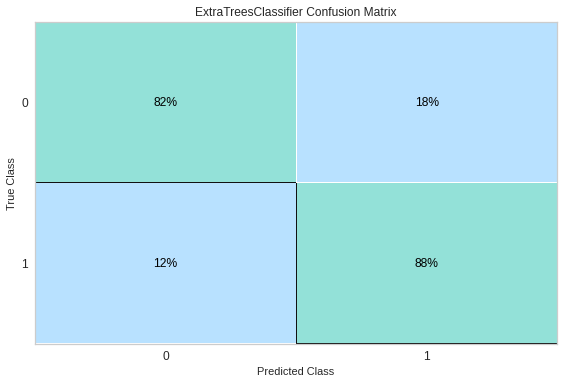

In [ ]:
colors = ['#b8e1ff', '#93e1d8']

cm = ConfusionMatrix(final_pipe, classes = [0, 1], percent = True, cmap=colors)
set_palette('pastel')
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.ax.set_xticklabels([0,1], rotation=0)
cm.show();

### ROC Curve

In [ ]:
import numpy as np

In [ ]:
pred_positive = final_pipe.predict_proba(X_val)[:,1]
fprs, tprs, thresholds = roc_curve(y_val, pred_positive)

thr_idx = np.arange(1, thresholds.shape[0], 6)

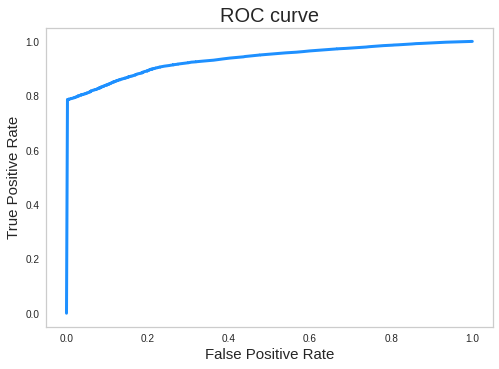

In [ ]:
plt.plot(fprs, tprs, color = 'dodgerblue', linestyle = '-', linewidth = 3, label = 'ROC')
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC curve', fontsize = 20)
plt.grid(False)
plt.show();

### 특성 중요도

In [ ]:
from eli5.sklearn import PermutationImportance
import eli5

In [ ]:
trees = final_pipe.named_steps['tree']
importances = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importances': trees.feature_importances_
    }
)

importances = importances.sort_values(by=['Importances']).reset_index(drop = True)
importances

,Feature,Importances
0,House_Ownership,0.007323
1,Married_Or_Single,0.010838
2,Car_Ownership,0.013734
3,Profession,0.033291
4,CURRENT_JOB_YRS,0.038152
5,Experience,0.048917
6,STATE,0.071506
7,Age,0.083115
8,CURRENT_HOUSE_YRS,0.136931
9,Income,0.556193


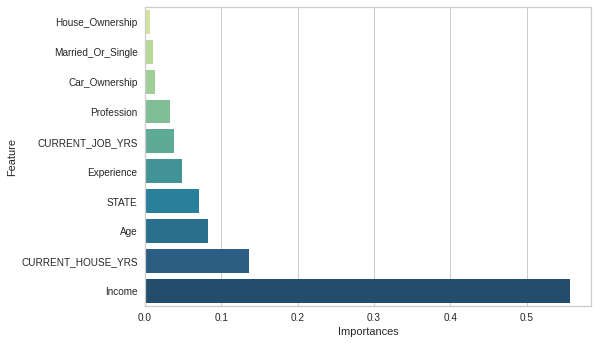

In [ ]:
colors = ['#d9ed92', '#b5e48c', '#99d98c', '#76c893', '#52b69a', 
          '#34a0a4', '#168aad', '#1a759f', '#1e6091', '#184e77']

sns.barplot(
    data = importances,
    x = 'Importances',
    y = 'Feature',
    palette = colors
);